<a href="https://colab.research.google.com/github/MariiaKalinina/BM/blob/main/Pressure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad

# 2.2.1 Basic Formulation

## Hydrostatic and Lithostatic Pressure, p.38

In [150]:
# Constants
g = 9.81  # gravitational acceleration in m/s^2
rho_sea = 1100  # density of sea water in kg/m^3
rho_w = 1040  # density of pore water in kg/m^3
rho_shale = 2700  # density of shale in kg/m^3
rho_sandstone = 2720  # density of sandstone in kg/m^3
water_depth = 1000  # water depth hw = 1 km in meters

In [158]:
def hydrostatic_pressures(depths, sea_level, sediment_surface, water_depth, rho_water=1040):

    """
    Calculate cumulative hydrostatic pressures for each layer.

    Parameters:
    - depths: List or array of bottom depth of each layer (m)
    - water_depth: Depth of water (m)
    - sediment_surface: Depth of sediment surface (m)
    - rho_water: Constant value of sea water density (kg/m^3)

    Returns:
    - List of cumulative pressures (MPa) for each layer and depth array
    """

    g = 9.81  # acceleration due to gravity in m/s^2
    pressures = [quad(lambda z: rho_water * g, sea_level, depth)[0] / 1e6 for depth in depths]  # Convert Pa to MPa

    return pressures

In [159]:
def lithostatic_pressures(layer_bottom_depth, rock_densities, porosities, sea_level,
                          water_depth, sediment_surface):
    """
    Calculate cumulative lithostatic pressures for each layer.

    Parameters:
    - layer_thicknesses: List or array of thicknesses of each layer (m)
    - rock_densities: List or array of densities of each rock layer (kg/m^3)
    - porosities: List or array of porosity values for each layer (fraction)
    - water_depth: Constant value of a water depth (m)

    Returns:
    - List of cumulative pressures (MPa) for each layer
    """
    g = 9.81  # acceleration due to gravity in m/s^2
    rho_sea = 1100
    pressures = []
    total_depth = 0
    total_pressure = 0

    if sediment_surface < 0:

      filtered_depths = np.insert(layer_bottom_depth, 0, sediment_surface)
      rock_densities = np.insert(rock_densities, 0, 0)
      porosities = np.insert(porosities, 0, 0)    # Add sediment porosity at the start


      for depth, density, porosity in zip(filtered_depths, rock_densities, porosities):
        total_pressure = 0
        effective_density = density * (1 - porosity) + rho_sea*porosity

        water_pressure = rho_sea * g * water_depth
        pressure_increment = quad(lambda z: effective_density * g, sediment_surface, depth)[0]
        total_pressure += water_pressure
        total_pressure += pressure_increment

        pressures.append((total_pressure) / 1e6)  # Convert Pa to MPa

      return pressures

    else:

      filtered_depths = [depth for depth in layer_bottom_depth if depth > sediment_surface]
      filtered_depths.insert(0, sediment_surface)

      for depth, density, porosity in zip(filtered_depths, rock_densities, porosities):

          total_pressure = 0
          effective_density = density * (1 - porosity) + rho_sea*porosity

          water_pressure = rho_sea * g * water_depth
          pressure_increment = quad(lambda z: effective_density * g, sediment_surface, depth)[0]
          total_pressure += water_pressure
          total_pressure += pressure_increment

          pressures.append((total_pressure) / 1e6)  # Convert Pa to MPa

      return pressures

Hydrostatic pressures (MPa): [0.0, 15.303599999999996, 30.60719999999999, 45.910799999999995, 61.21439999999998]
Lithostatic pressures (MPa): [10.791, 24.0345, 63.76499999999999, 103.49549999999998, 143.226]


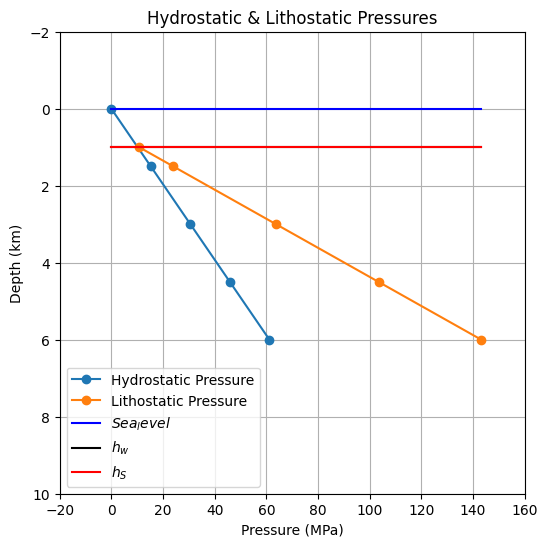

In [161]:
def pressure(pressure_types):

    SEA_LEVEL = 0
    SEDIMENT_SURFACE = 1000

    # Make initial data for calculation
    N = 5
    layer_bottom_depth = np.linspace(0, 6000, N)  # thickness of each layer in meters
    rock_densities = np.full(N, 2700)  # density of each rock layer in kg/m^3
    porosities = np.full(N, 0.0)  # porosity of each layer

    if SEDIMENT_SURFACE >=0:
      WATER_DEPTH = SEDIMENT_SURFACE
    else:
      WATER_DEPTH = SEA_LEVEL


    if 'hydrostatic' in pressure_types:
        pressures_hydrostatic = hydrostatic_pressures(layer_bottom_depth,
                                                      sea_level = SEA_LEVEL,
                                                      sediment_surface = SEDIMENT_SURFACE,
                                                      water_depth=WATER_DEPTH)
        print("Hydrostatic pressures (MPa):", pressures_hydrostatic)

    if 'lithostatic' in pressure_types:
        lith_pressures = lithostatic_pressures(layer_bottom_depth, rock_densities, porosities, sea_level=SEA_LEVEL,
                                               water_depth=WATER_DEPTH, sediment_surface=SEDIMENT_SURFACE)

        print("Lithostatic pressures (MPa):", lith_pressures)


    # Visualization

    plt.figure(figsize=(6, 6))
    ax1 = plt.subplot(1, 1, 1)

    if 'hydrostatic' in pressure_types:
        plt.plot(pressures_hydrostatic, layer_bottom_depth / 1000, label='Hydrostatic Pressure', marker='o')  # Convert depths to km
    if 'lithostatic' in pressure_types:

        if SEDIMENT_SURFACE < 0:
          depth_new = np.insert(layer_bottom_depth/1000, 0, SEDIMENT_SURFACE/1000)
          plt.plot(lith_pressures, depth_new, label='Lithostatic Pressure', marker='o')  # Convert layer depths to km
        else:
          depth_new = [depth/1000 for depth in layer_bottom_depth if depth > SEDIMENT_SURFACE]
          depth_new.insert(0, np.abs(SEDIMENT_SURFACE/1000))
          plt.plot(lith_pressures, depth_new, label='Lithostatic Pressure', marker='o')  # Convert layer depths to km


    plt.plot([np.min(pressures_hydrostatic), np.max(lith_pressures)],
     [SEA_LEVEL*1e-3, SEA_LEVEL*1e-3], color='blue', label=f'$Sea_level$') # Sea water level (hw)

    plt.plot([np.min(pressures_hydrostatic), np.max(lith_pressures)],
     [WATER_DEPTH*1e-3, WATER_DEPTH*1e-3], color='black', label=f'$h_w$') # Sea water level (hw)

    plt.plot([np.min(pressures_hydrostatic), np.max(lith_pressures)],
     [SEDIMENT_SURFACE*1e-3, SEDIMENT_SURFACE*1e-3], color='RED', label=f'$h_S$') # Surface level (hs)


    plt.title('Hydrostatic & Lithostatic Pressures')
    plt.ylabel('Depth (km)')
    plt.xlabel('Pressure (MPa)')
    plt.ylim(10, -2)  # Set limits after converting depths to km
    plt.xlim([np.min(pressures_hydrostatic), np.max(lith_pressures)])
    plt.xlim(-20, 160)
    plt.legend()
    plt.grid(True)
    plt.show()

pressure(['hydrostatic', 'lithostatic'])

# Pore Pressure: Terzaghi Type Models

## Athy’s Law formulated with Effective Stress

In [ ]:
shale = {
    'porosity initial': 0.70,
    'decline angle': 0.096
}

siltstone = {
    'porosity initial': 0.55,
    'decline angle': 0.049
}

sandstone = {
    'porosity initial': 0.41,
    'decline angle': 0.0266
}

Eq. (2.20)

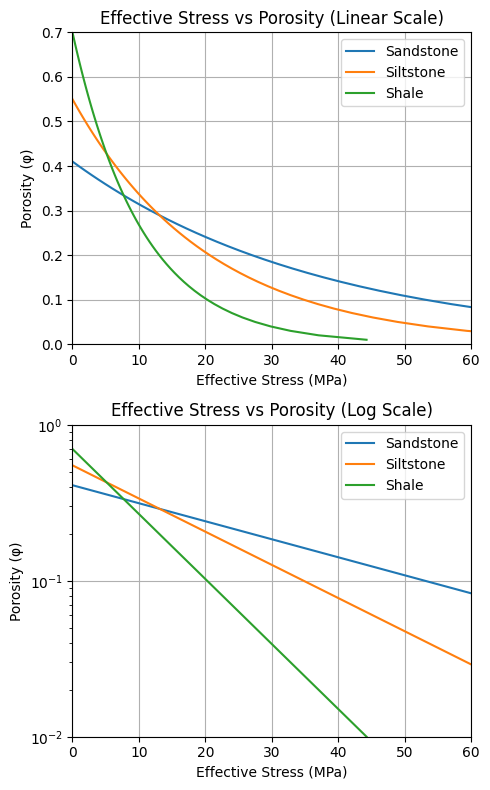

In [175]:
import numpy as np
import matplotlib.pyplot as plt

def arty_model(phi_array, phi0, k):
    if phi0 <= 0 or k <= 0:
        raise ValueError("phi0 and k must be positive values.")

    return [- (1 / k) * np.log(phi / phi0) for phi in phi_array]

# Example lithology data
sandstone = {'porosity initial': 0.41, 'k': 0.0266}
siltstone = {'porosity initial': 0.55, 'k': 0.049}
shale = {'porosity initial': 0.70, 'k': 0.096}

# List of lithology types
lithology_types = ['sandstone', 'siltstone', 'shale']

# Prepare the plot
plt.figure(figsize=(5, 8))

# Porosity array
phi_array = np.linspace(0.01, 1, 100)  # Start from a small positive value to avoid log(0)

# Iterate through each lithology type and calculate effective stress
for lithology in lithology_types:
    if lithology == 'sandstone':
        phi0 = sandstone['porosity initial']
        k = sandstone['k']
    elif lithology == 'siltstone':
        phi0 = siltstone['porosity initial']
        k = siltstone['k']
    elif lithology == 'shale':
        phi0 = shale['porosity initial']
        k = shale['k']

    # Calculate effective stress for the current lithology
    sigma_effective = arty_model(phi_array, phi0, k)

    # Plotting effective stress against porosity in linear scale
    plt.subplot(2, 1, 1)
    plt.plot(sigma_effective, phi_array, label=f'{lithology.capitalize()}')
    plt.title('Effective Stress vs Porosity (Linear Scale)')
    plt.ylabel('Porosity (φ)')
    plt.xlabel('Effective Stress (MPa)')
    plt.xlim(0, 60)
    plt.ylim(0, 0.7)
    plt.grid(True)
    plt.legend()

    # Plotting effective stress against porosity in logarithmic scale
    plt.subplot(2, 1, 2)
    plt.plot(sigma_effective, phi_array, label=f'{lithology.capitalize()}')
    plt.title('Effective Stress vs Porosity (Log Scale)')
    plt.ylabel('Porosity (φ)')
    plt.xlabel('Effective Stress (MPa)')
    plt.xlim(0, 60)
    plt.ylim(0.01, 1)  # Avoid log(0) by starting from a small positive value
    plt.yscale('log')   # Set y-axis to logarithmic scale
    plt.grid(True)
    plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

Eq. (2.23)

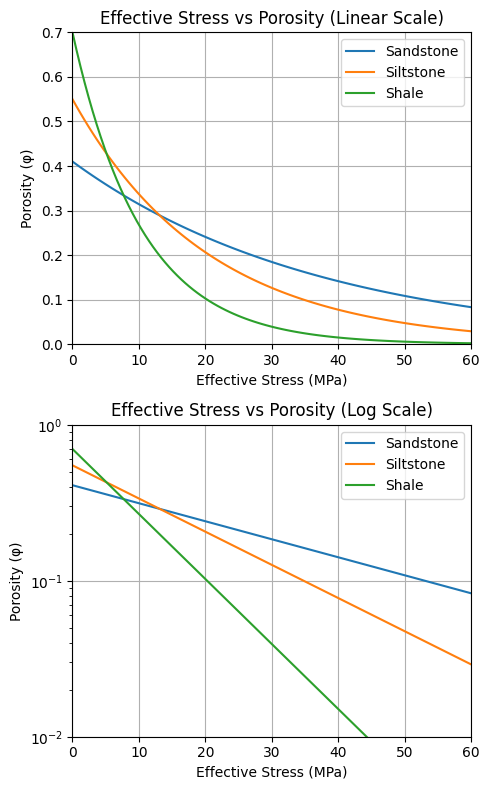

In [174]:
import numpy as np
import matplotlib.pyplot as plt

def arty_model_porosity(sigma_z_array, phi0, phi_m, k):
    return [phi_m + (phi0 - phi_m) * np.exp(-k * sigma_z) for sigma_z in sigma_z_array]

# Example lithology data
sandstone = {'porosity initial': 0.41, 'k': 0.0266}
siltstone = {'porosity initial': 0.55, 'k': 0.049}
shale = {'porosity initial': 0.70, 'k': 0.096}

# List of lithology types
lithology_types = ['sandstone', 'siltstone', 'shale']

# Prepare the plot
plt.figure(figsize=(5, 8))

# Effective stress array
sigma_z_array = np.linspace(0., 60, 100)  # Effective stress in MPa
phi_m = 0  # Minimum porosity

# Iterate through each lithology type and calculate porosity
for lithology in lithology_types:
    if lithology == 'sandstone':
        phi0 = sandstone['porosity initial']
        k = sandstone['k']
    elif lithology == 'siltstone':
        phi0 = siltstone['porosity initial']
        k = siltstone['k']
    elif lithology == 'shale':
        phi0 = shale['porosity initial']
        k = shale['k']

    # Calculate effective porosity for the current lithology
    porosity_effective = arty_model_porosity(sigma_z_array, phi0, phi_m, k)

    # Plotting effective stress against porosity in linear scale
    plt.subplot(2, 1, 1)
    plt.plot(sigma_z_array, porosity_effective, label=f'{lithology.capitalize()}')
    plt.title('Effective Stress vs Porosity (Linear Scale)')
    plt.ylabel('Porosity (φ)')
    plt.xlabel('Effective Stress (MPa)')
    plt.xlim(0, 60)
    plt.ylim(0, 0.7)
    plt.grid(True)
    plt.legend()

    # Plotting effective stress against porosity in logarithmic scale
    plt.subplot(2, 1, 2)
    plt.plot(sigma_z_array, porosity_effective, label=f'{lithology.capitalize()}')
    plt.title('Effective Stress vs Porosity (Log Scale)')
    plt.ylabel('Porosity (φ)')
    plt.xlabel('Effective Stress (MPa)')
    plt.xlim(0, 60)
    plt.ylim(0.01, 1)  # Avoid log(0) by starting from a small positive value
    plt.yscale('log')   # Set y-axis to logarithmic scale
    plt.grid(True)
    plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

## Athy Model with Hydrostatic Depth

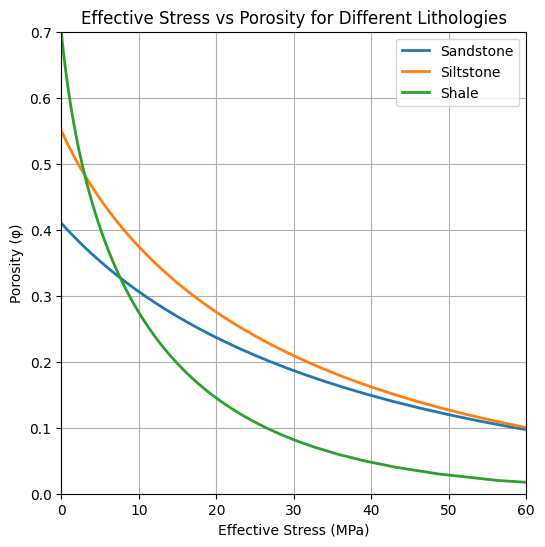

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def effective_stress(phi_array, phi0, k, rho_rock, rho_water=1040, g=9.81):
    delta_rho = (rho_rock - rho_water)/1000
    """Calculate effective stress based on the provided equation."""
    return (delta_rho * g / k) * (phi_array - phi0 - np.log(phi_array / phi0))

def porosity_from_stress(sigma, phi0, k, delta_rho=1.0, g=9.81, initial_guess=0.5, tol=1e-6, max_iter=100):
    """Calculate porosity from effective stress using Newton's method."""
    phi = initial_guess
    for _ in range(max_iter):
        # Calculate effective stress at current porosity
        sigma_current = effective_stress(np.array([phi]), phi0, k, delta_rho, g)[0]

        # Calculate derivative (numerical approximation)
        d_sigma_d_phi = (effective_stress(np.array([phi + tol]), phi0, k, delta_rho, g)[0] - sigma_current) / tol

        # Update porosity using Newton's method
        phi_new = phi - (sigma_current - sigma) / d_sigma_d_phi

        # Check for convergence
        if abs(phi_new - phi) < tol:
            return phi_new

        phi = phi_new

    return phi  # Return last computed value if not converged

# Define lithology properties
shale = {
    'porosity initial': 0.70,
    'decline angle': 0.83,
    'rock density': 2700
}

siltstone = {
    'porosity initial': 0.55,
    'decline angle': 0.34,
    'rock density': 2700
}

sandstone = {
    'porosity initial': 0.41,
    'decline angle': 0.31,
    'rock density': 2720
}

lithology_types = ['sandstone', 'siltstone', 'shale']

# Create an array of porosities
phi_array = np.linspace(0.01, 1, 100)  # Start from a small positive value

plt.figure(figsize=(6, 6))

# Loop through each lithology and calculate effective stress
for lithology in lithology_types:
    if lithology == 'sandstone':
        phi0 = sandstone['porosity initial']
        k = sandstone['decline angle']
        rho = sandstone['rock density']
    elif lithology == 'siltstone':
        phi0 = siltstone['porosity initial']
        k = siltstone['decline angle']  # Corrected line: removed trailing comma
        rho = siltstone['rock density']
    elif lithology == 'shale':
        phi0 = shale['porosity initial']
        k = shale['decline angle']
        rho = shale['rock density']

    # Calculate effective stress for the current lithology
    sigma_effective = effective_stress(phi_array, phi0=phi0, k=k,
                                       rho_rock=rho)

    # Plot the effective stress for the current lithology
    plt.plot(sigma_effective, phi_array, label=f'{lithology.capitalize()}', linewidth=2)

# Customize the plot
plt.title('Effective Stress vs Porosity for Different Lithologies')
plt.ylabel('Porosity (φ)')
plt.xlabel('Effective Stress (MPa)')
plt.grid(True)
plt.xlim(0, 60)
plt.ylim(0, 0.7)  # Adjusted to cover full range of porosity values
plt.legend()
plt.show()

## Schneider Model

Effective stress sigma_z at depth 1000 m is 10752468567264621269723061867401066998105374720.000 units
Porosity at depth 1000 m is 0.000


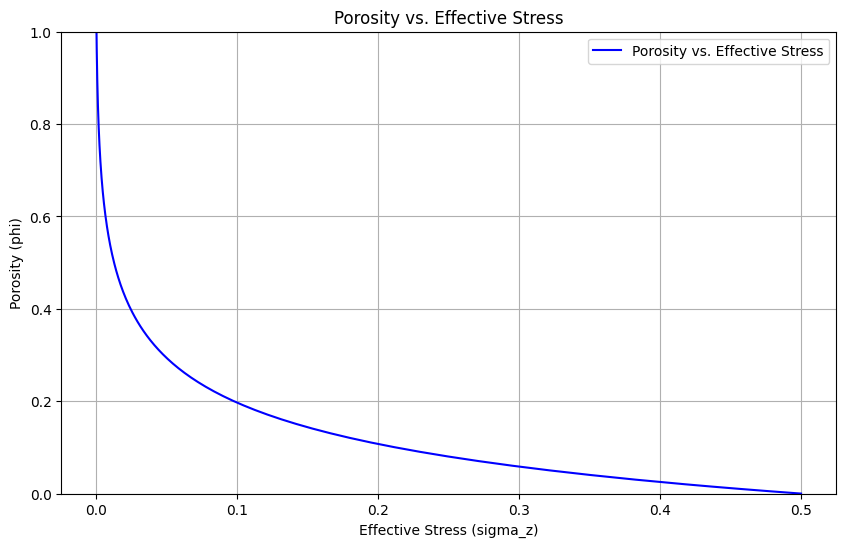

In [166]:
import numpy as np
from scipy.integrate import quad
from scipy.optimize import fsolve

# Define the porosity equation as per Schneider et al. (1996)
def porosity(sigma_z, phi1, phia, phib, ka, kb):
    """
    Calculate porosity based on the effective stress sigma_z.
    """
    return phi1 + phia * np.exp(-ka * sigma_z) + phib * np.exp(-kb * sigma_z)

# Define the compressibility function
def compressibility(sigma_z, phia, phib, ka, kb):
    """
    Calculate compressibility based on the effective stress sigma_z.
    """
    return ka * phia * np.exp(-ka * sigma_z) + kb * phib * np.exp(-kb * sigma_z)

# Function to perform numerical integration to find sigma_z from depth
def sigma_z_from_depth(z, phi0, phia, phib, ka, kb):
    """
    Numerically integrate the compressibility function to find sigma_z at a given depth z.
    """
    # Initial porosity parameters
    phi1 = phi0 - (phia + phib)

    # Define the integrand function
    def integrand(sigma_z):
        return 1 / compressibility(sigma_z, phia, phib, ka, kb)

    # Perform numerical integration
    integral_result, _ = quad(integrand, 0, z)
    return integral_result

# Example parameters
phi0 = 0.5  # Initial porosity
phia = phi0 / 2
phib = phi0 / 2
ka = 0.1
kb = 0.2
depth = 1000  # Depth at which we want to find sigma_z
phi1 = phi0 - (phia + phib)


# Calculate sigma_z for a given depth
sigma_z_at_depth = sigma_z_from_depth(depth, phi0, phia, phib, ka, kb)
print(f"Effective stress sigma_z at depth {depth} m is {sigma_z_at_depth:.3f} units")

# Calculate porosity at this depth using the porosity equation
phi_at_depth = porosity(sigma_z_at_depth, phi0 - (phia + phib), phia, phib, ka, kb)
print(f"Porosity at depth {depth} m is {phi_at_depth:.3f}")

# Generate a range of sigma_z values
porosities = np.linspace(0, 1, 200)  # Effective stress from 0 to 5000 units

effective_stress = np.linspace(0, 60, 200)  # Effective stress from 0 to 5000 units

# Calculate porosity for each sigma_z
sigma_z_values = [porosity(sigma_z, phi1, phia, phib, ka, kb) for sigma_z in effective_stress]

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(sigma_z_values, porosities, label='Porosity vs. Effective Stress', color='blue')
plt.title('Porosity vs. Effective Stress')
plt.xlabel('Effective Stress (sigma_z)')
plt.ylabel('Porosity (phi)')
plt.grid(True)
plt.ylim(0, 1)  # Adjust y-axis limits based on expected porosity values
plt.legend()
plt.show()

## Compressibility Model

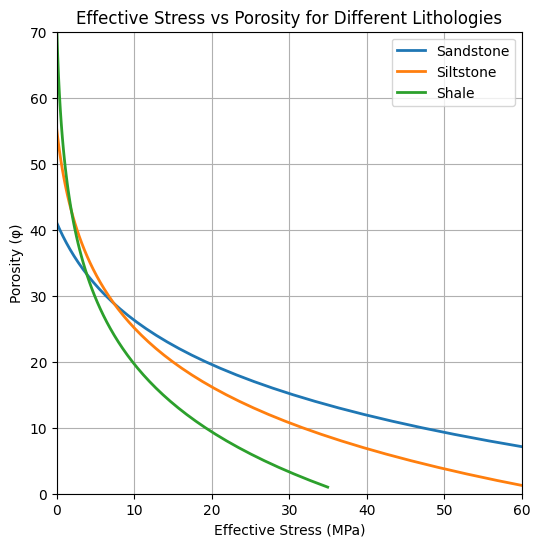

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# def effective_stress(phi_array, phi0, k, rho_rock, rho_water=1040, g=9.81):
#     delta_rho = (rho_rock - rho_water)/1000
#     """Calculate effective stress based on the provided equation."""
#     return (delta_rho * g / k) * (phi_array - phi0 - np.log(phi_array / phi0))


def calculate_alpha(phi0, phim, Cm, C0):
    """
    Calculate alpha based on the given formula.
    """
    return np.exp((phi0 * np.log(Cm) - phim * np.log(C0)) / (phi0 - phim))


def calculate_beta(phi0, phim, Cm, C0):
    """
    Calculate alpha based on the given formula.
    """
    return (np.log(C0) - np.log(Cm)) / (phi0 - phim)


def effective_stress_compresseibility_model(phi, phi0, phim, Cm, C0):
    """
    Calculate sigma_z based on the porosity function.

    """
    alpha = calculate_alpha(phi0, phim, Cm, C0)
    beta = calculate_beta(phi0, phim, Cm, C0)

    return (np.exp(-beta * phi) - np.exp(-beta * phi0)) / (alpha * beta)



# Define lithology properties
shale = {
    'porosity initial': 0.70,
    'decline angle': 0.83,
    'rock density': 2700,
    'C0': 403,
    'Cm' : 4.03
}

siltstone = {
    'porosity initial': 0.55,
    'decline angle': 0.34,
    'rock density': 2700,
    'C0': 103,
    'Cm' : 2.11
}

sandstone = {
    'porosity initial': 0.41,
    'decline angle': 0.31,
    'rock density': 2720,
    'C0': 27.5,
    'Cm' : 1.15
}

lithology_types = ['sandstone', 'siltstone', 'shale']

# Create an array of porosities
phi_array = np.linspace(0.01, 1, 100)  # Start from a small positive value

plt.figure(figsize=(6, 6))

# Loop through each lithology and calculate effective stress
for lithology in lithology_types:
    if lithology == 'sandstone':
        phi0 = sandstone['porosity initial']
        k = sandstone['decline angle']
        rho = sandstone['rock density'],
        C0 = sandstone['C0'],
        Cm = sandstone['Cm']
    elif lithology == 'siltstone':
        phi0 = siltstone['porosity initial']
        k = siltstone['decline angle']  # Corrected line: removed trailing comma
        rho = siltstone['rock density'],
        C0 = siltstone['C0'],
        Cm = siltstone['Cm']
    elif lithology == 'shale':
        phi0 = shale['porosity initial']
        k = shale['decline angle']
        rho = shale['rock density'],
        C0 = shale['C0'],
        Cm = shale['Cm']

    # Calculate effective stress for the current lithology
    phim=0
    sigma_effective = effective_stress_compresseibility_model(phi_array, phi0, phim, Cm, C0)

    # Plot the effective stress for the current lithology
    plt.plot(sigma_effective*1000, phi_array*100, label=f'{lithology.capitalize()}', linewidth=2)

# Customize the plot
plt.title('Effective Stress vs Porosity for Different Lithologies')
plt.ylabel('Porosity (φ)')
plt.xlabel('Effective Stress (MPa)')
plt.grid(True)
plt.xlim(0, 60)
plt.ylim(0, 70)  # Adjusted to cover full range of porosity values
plt.legend()
plt.show()

## Mudstone Model

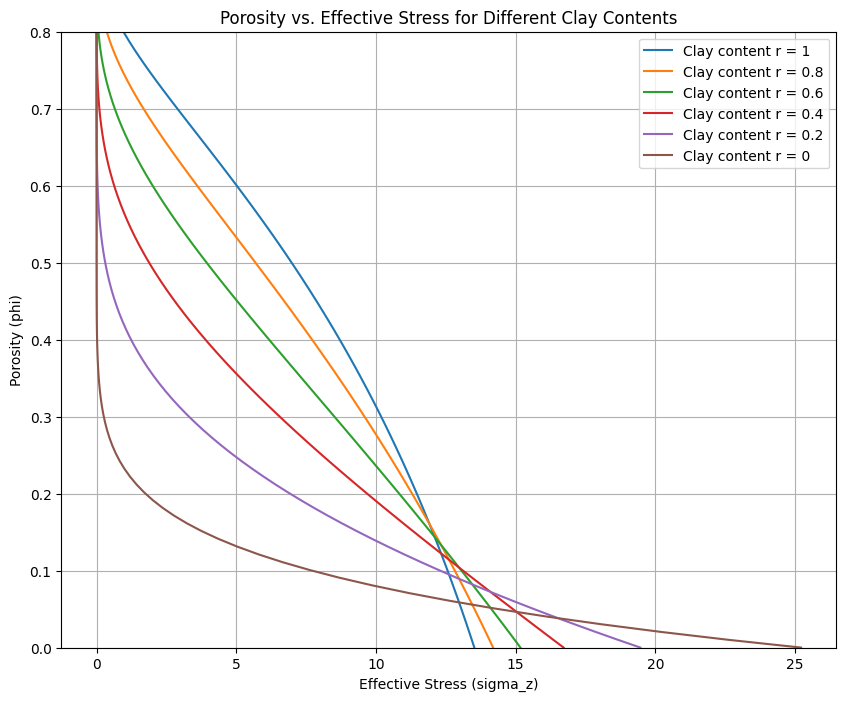

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

def e100(r):
    """Calculate initial void ratio e100 based on clay content r."""
    return 0.3024 + 1.6867 * r + 1.9505 * r**2

def beta(r):
    """Calculate compressibility beta based on clay content r."""
    return 0.0937 + 0.5708 * r + 0.8483 * r**2

def calculate_sigma_z(phi, e_100, beta):
    """Calculate effective stress sigma_z based on porosity phi, initial void ratio e_100, and compressibility beta."""
    if phi == 1:
        return float('inf')  # Avoid division by zero as phi approaches 1
    phi_term = phi / (1 - phi)
    exponent = (e_100 - phi_term) / beta
    sigma_z = 0.1* math.exp(exponent)
    return sigma_z

# Clay content values
r_values = [1, 0.8, 0.6, 0.4, 0.2, 0]
phi_values = np.linspace(0, 0.999, 100)  # Avoiding phi = 1

# Plotting
plt.figure(figsize=(10, 8))

for r in r_values:
    e_100_value = e100(r)
    beta_value = beta(r)
    sigma_z_values = [calculate_sigma_z(phi, e_100_value, beta_value) for phi in phi_values]
    plt.plot(sigma_z_values, phi_values, label=f'Clay content r = {r}')

plt.ylabel('Porosity (phi)')
plt.xlabel('Effective Stress (sigma_z)')
plt.title('Porosity vs. Effective Stress for Different Clay Contents')
plt.grid(True)
plt.ylim(0, 0.8)
plt.legend()
plt.show()

# Viscosity

## Viscosity (McCain)

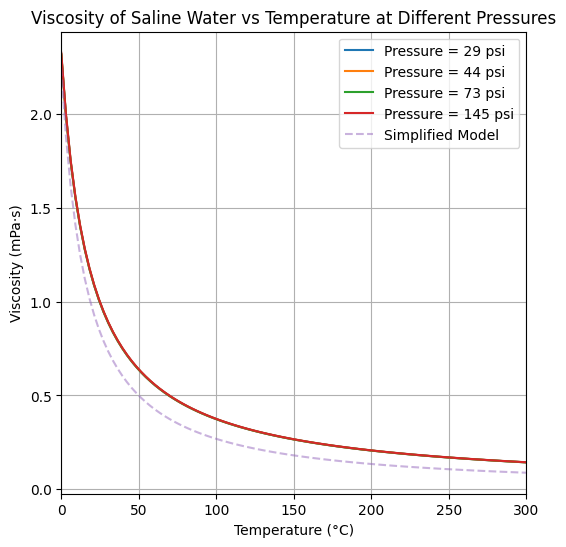

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def viscosity_McCain(s, T, P):
    """
    Calculate viscosity of saline water.

    Parameters:
    - s: Salinity (%), s < 26%
    - T: Temperature (°C), 38 < T < 200
    - P: Pressure (psi), P < 100 MPa

    Returns:
    - Viscosity (mPa·s) depending on temperature
    """
    a = 1.12166 - 2.63951 * 10**-2 * s + 6.79461 * 10**-4 * s**2 + 5.47119 * 10**-5 * s**3 - 1.55586 * 10**-6 * s**4
    vT = T**-a * (109.547 - 8.40564 * s + 0.313314 * s**2 + 8.72213 * 10**-3 * s**3)
    v = vT * (0.9994 + 4.0295 * 10**-5 * P + 3.1062 * 10**-9 * P**2)

    return v

def simplified_viscosity(T): # without salinity and pressure
    """
    Simplified viscosity calculation based on temperature alone.

    Parameters:
    - T: Temperature (°C)

    Returns:
    - Viscosity (mPa·s)
    """
    return 109.5 * T**(-1.122)

def mp_to_psi(mp):
    """
    Convert pressure from megapascals (MPa) to pounds per square inch (psi).

    Parameters:
    - mp: Pressure in MPa

    Returns:
    - Pressure in psi
    """
    return mp * 145.0377

def celsius_to_fahrenheit(c):
    """
    Convert temperature from Celsius to Fahrenheit.

    Parameters:
    - c: Temperature in Celsius

    Returns:
    - Temperature in Fahrenheit
    """
    return (c * 9/5) + 32

# Constants
s = 10  # Salinity in %

#Define pressure values in MPa
pressure_mpa = np.array([0.2, 0.3, 0.5, 1])  # Example pressures in MPa
# Convert to psi
pressure_psi = mp_to_psi(pressure_mpa)


# Create an array of temperatures (C)
temperature_array_C = np.linspace(0, 300, 100) # Start from 38°C to comply with constraints
temperature_array_F = celsius_to_fahrenheit(temperature_array_C)

# Plotting
plt.figure(figsize=(6, 6))

# Calculate viscosity for each temperature and pressure
for P in pressure_psi:
    viscosity_values = [viscosity_McCain(s=s, T=T, P=P) for T in temperature_array_F]

    # Plot the viscosity for the current pressure
    plt.plot(temperature_array_C, viscosity_values, label=f'Pressure = {P:0.0f} psi')

simplified_viscosity_values = [simplified_viscosity(T) for T in temperature_array_F]
plt.plot(temperature_array_C, simplified_viscosity_values, '--', label='Simplified Model', alpha=0.5)
# Customize the plot
plt.title('Viscosity of Saline Water vs Temperature at Different Pressures')
plt.ylabel('Viscosity (mPa·s)')
plt.xlabel('Temperature (°C)')
plt.grid(True)
plt.legend()
plt.xlim(0, 300) # Set limits according to temperature range
plt.show()

## Viscosity (Hewlett-Packard)

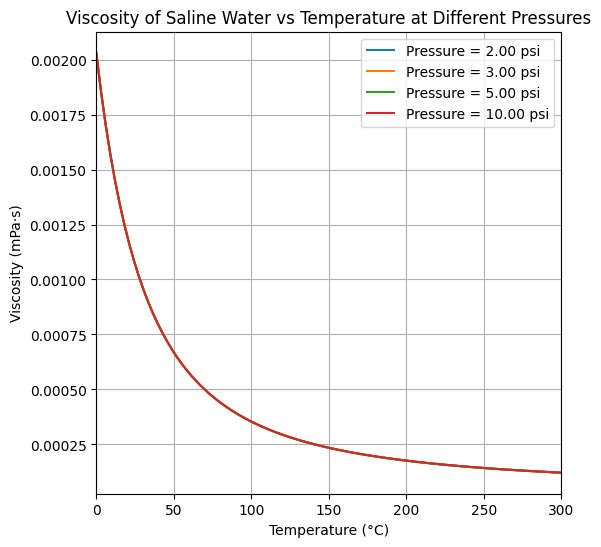

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def viscosity_HP(s, T, Tk, P):
    """
    Calculate viscosity of saline water.

    Parameters:
    - s: Salinity (%), s < 26%
    - T: Temperature (°C), 38 < T < 200
    - P: Pressure (psi), P < 100 MPa

    Returns:
    - Viscosity (mPa·s) depending on temperature
    """
    v0 = 243.18 * 10**-7 * 10**(247.8/(Tk-140)) * (1 + 1.0467 * 10**-6 * P * (Tk - 305))
    v = v0 * (1 - 1.87*10**-3 * s**0.5 + 2.18*10**-4 * s**2.5 + (T**0.5 - 0.0135*T) * (2.76*10**-3*s - 3.44*10**-4 * s**1.5))
    return v

def mp_to_psi(mp):
    """
    Convert pressure from megapascals (MPa) to pounds per square inch (psi).

    Parameters:
    - mp: Pressure in MPa

    Returns:
    - Pressure in psi
    """
    return mp * 145.0377

def mp_to_bar(mp):
    """
    Convert pressure from megapascals (MPa) to bar.

    Parameters:
    - mp: Pressure in MPa

    Returns:
    - Pressure in bar
    """
    return mp * 10

# Constants
s = 10  # Salinity in %

# Define pressure values in MPa
pressure_mpa = np.array([0.2, 0.3, 0.5, 1])  # Example pressures in MPa
pressure_psi = mp_to_psi(pressure_mpa) # Convert to psi
pressure_bar = mp_to_bar(pressure_mpa)


# Create an array of temperatures (C)
temperature_array_C = np.linspace(0, 300, 100)  # Corrected temperature range
temperature_array_K = temperature_array_C + 273.15  # Convert to Kelvin
temperature_array_F = (temperature_array_C * 9/5) + 32 # Convert to Fahrenheit

# Plotting
plt.figure(figsize=(6, 6))

# Calculate viscosity for each temperature and pressure
for P in pressure_bar:
    viscosity_values = [viscosity_HP(s=s, T=T, Tk=Tk, P=P) for T, Tk in zip(temperature_array_F , temperature_array_K)]

    # Plot the viscosity for the current pressure
    plt.plot(temperature_array_C, viscosity_values, label=f'Pressure = {P:.2f} psi')

# Customize the plot
plt.title('Viscosity of Saline Water vs Temperature at Different Pressures')
plt.ylabel('Viscosity (mPa·s)')
plt.xlabel('Temperature (°C)')
plt.grid(True)
plt.legend()
plt.xlim(0, 300)  # Set limits according to temperature range
plt.show()

# Permeability

<ipython-input-30-05d4a54471fd>:11: RuntimeWarning: divide by zero encountered in scalar divide
  return 2 * 10**14 * k * (phi**3 / (S**2 * (1 - phi)**2))


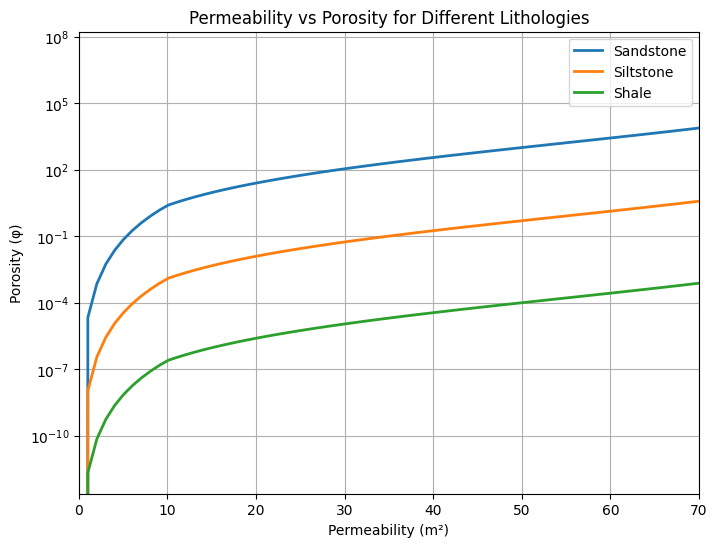

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def Kozeny_Carman(r, phi, tau):
    return r**2 * phi / (8 * tau**2)

def Kozeny_Carman_lithology(phi, k, S):
    if phi < 0.1:
        return 2 * 10**16 * k * (phi**5 / (S**2 * (1 - phi)**2))
    else:
        return 2 * 10**14 * k * (phi**3 / (S**2 * (1 - phi)**2))

# Define lithology properties
shale = {
    'spec. surf. area': 10**8,
    'k': 0.01
}

siltstone = {
    'spec. surf. area': 10**7,
    'k': 0.5
}

sandstone = {
    'spec. surf. area': 10**6,
    'k': 10.0
}

lithology_types = ['sandstone', 'siltstone', 'shale']

# Create an array of porosities
phi_array = np.linspace(0.0, 1, 100)  # Start from a small positive value

plt.figure(figsize=(8, 6))

# Loop through each lithology and calculate effective stress
for lithology in lithology_types:
    if lithology == 'sandstone':
        k = sandstone['k']
        SSA = sandstone['spec. surf. area']
    elif lithology == 'siltstone':
        k = siltstone['k']
        SSA = siltstone['spec. surf. area']
    elif lithology == 'shale':
        k = shale['k']
        SSA = shale['spec. surf. area']

    # Calculate permeability for the current lithology
    permeability = [Kozeny_Carman_lithology(phi, k=k, S=SSA) for phi in phi_array]

    # Plot the permeability for the current lithology
    plt.plot(phi_array*100, permeability, label=f'{lithology.capitalize()}', linewidth=2)

# Customize the plot
plt.title('Permeability vs Porosity for Different Lithologies')
plt.ylabel('Porosity (φ)')
plt.xlabel('Permeability (m²)')
plt.grid(True)
plt.xlim(0, 70)

# Set y-axis to logarithmic scale
plt.yscale('log')

plt.legend()
plt.show()

In [ ]:
# Given pressures
hydrostatic_pressures = [10.202399999999999, 20.404799999999998, 30.60719999999999,
                          40.809599999999996, 51.01199999999999, 61.21439999999998]

lithostatic_pressures = [26.486999999999995, 52.97399999999999, 79.46099999999998,
                         105.94799999999998, 132.43499999999997, 158.92199999999997]

# Calculate differences
pressure_differences = [litho - hydro for litho, hydro in zip(lithostatic_pressures, hydrostatic_pressures)]

# Display the results
print("Pressure Differences (Lithostatic - Hydrostatic):")
print(pressure_differences)

Pressure Differences (Lithostatic - Hydrostatic):
[16.284599999999998, 32.569199999999995, 48.85379999999999, 65.13839999999999, 81.42299999999997, 97.70759999999999]


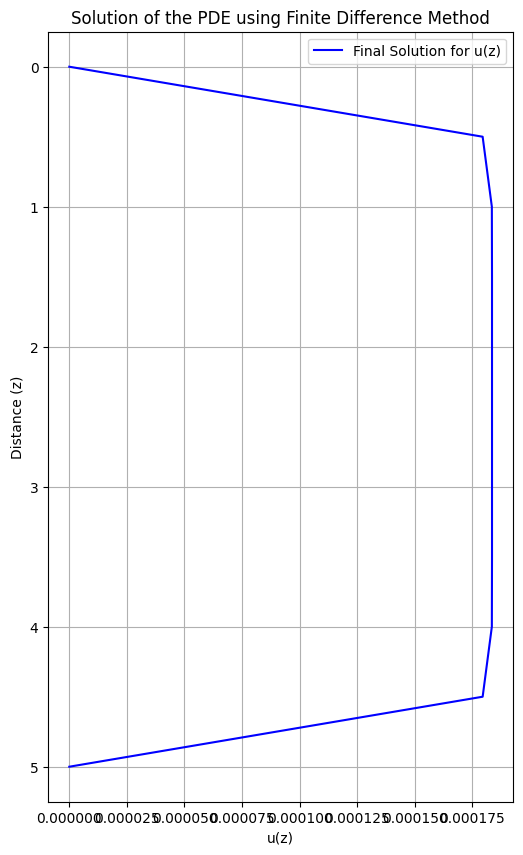

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
C = 10**-4       # Constant C
k = 10           # Permeability k
nu = pressure_differences        # Viscosity nu
L = 5            # Length of the domain in z (km)
T = 10           # Total time (seconds)
dz = 0.5         # Spatial step size (km)
dt = 0.01        # Time step size (seconds)

# Derived parameters
z_points = int(L / dz) + 1
t_points = int(T / dt) + 1

# Initialize arrays
u = np.zeros(z_points)        # Solution array for u
u_l = np.zeros(t_points)      # Assume some known function for u_l

# Example: Define u_l as a function of time (could be any function)
for t in range(t_points):
    u_l[t] = np.sin(t * dt)  # Example: sinusoidal variation

# Time-stepping loop
for t in range(1, t_points):
    for z in range(1, z_points - 1):
        du_dt = (k / nu) * (u[z + 1] - 2 * u[z] + u[z - 1]) / (dz**2)  # Central difference in space
        u[z] += dt * (C * du_dt + C * (u_l[t] - u[z]))  # Update rule based on the equation

# Plotting the results
z_array = np.linspace(0, L, z_points)
plt.figure(figsize=(6, 10))
plt.plot(u, z_array, label='Final Solution for u(z)', color='blue')
plt.title('Solution of the PDE using Finite Difference Method')
plt.ylabel('Distance (z)')
plt.xlabel('u(z)')
plt.grid(True)
plt.legend()

# Invert y-axis
plt.gca().invert_yaxis()

plt.show()

[0. 1. 2. 3. 4. 5. 6.]
[ 0.         -0.181962   -0.30858067 -0.36976802 -0.36736012 -0.2789815
  0.        ]


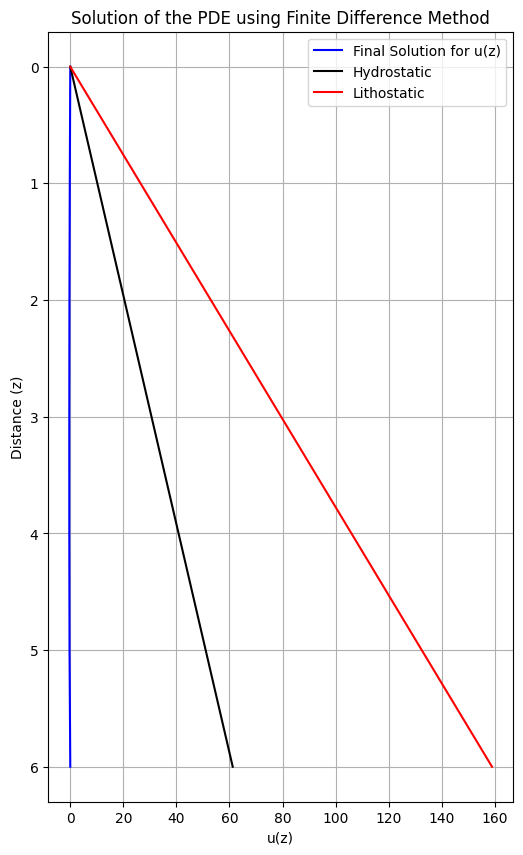

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Given pressures (example values for hydrostatic and lithostatic)
hydrostatic_pressures = [0, 10.2024, 20.4048, 30.6072, 40.8096, 51.0120, 61.2144]
lithostatic_pressures = [0, 26.4870, 52.9740, 79.4610, 105.9480, 132.4350, 158.9220]

# Calculate pressure differences
pressure_differences = [litho - hydro for litho, hydro in zip(lithostatic_pressures, hydrostatic_pressures)]

# Parameters
C = 10       # Constant C
k = 100           # Permeability k
L = 6            # Length of the domain in z (km) - adjusted to match depth range
T = 10           # Total time (seconds)
dz = 1           # Spatial step size (km)
dt = 0.01        # Time step size (seconds)

# Derived parameters
z_points = int(L / dz) + 1
t_points = int(T / dt) + 1

# Initialize arrays
u = np.zeros(z_points)        # Solution array for u
u_l = np.zeros(t_points)      # Assume some known function for u_l

# Example: Define u_l as a function of time (could be any function)
for t in range(t_points):
    u_l[t] = np.sin(t * dt)  # Example: sinusoidal variation

# Time-stepping loop
for t in range(1, t_points):
    for z in range(1, z_points - 1):
        # Use pressure difference corresponding to current depth z
        nu = pressure_differences[z] if z < len(pressure_differences) else pressure_differences[-1]

        du_dt = (k / nu) * (u[z + 1] - 2 * u[z] + u[z - 1]) / (dz**2)  # Central difference in space
        u[z] += dt * (C * du_dt + C * (u_l[t] - u[z]))  # Update rule based on the equation

# Plotting the results
z_array = np.linspace(0, L, z_points)
print(z_array)
print(u)
plt.figure(figsize=(6, 10))
plt.plot(u, z_array, label='Final Solution for u(z)', color='blue')
plt.plot(hydrostatic_pressures, z_array, label='Hydrostatic', color='black')
plt.plot(lithostatic_pressures, z_array, label='Lithostatic', color='red')
plt.title('Solution of the PDE using Finite Difference Method')
plt.ylabel('Distance (z)')
plt.xlabel('u(z)')
plt.grid(True)
plt.legend()

# Invert y-axis
plt.gca().invert_yaxis()

plt.show()

[0. 1. 2. 3. 4. 5. 6.]
[ 0.         -0.19123431 -0.32231174 -0.38458097 -0.38215027 -0.2921432
  0.        ]


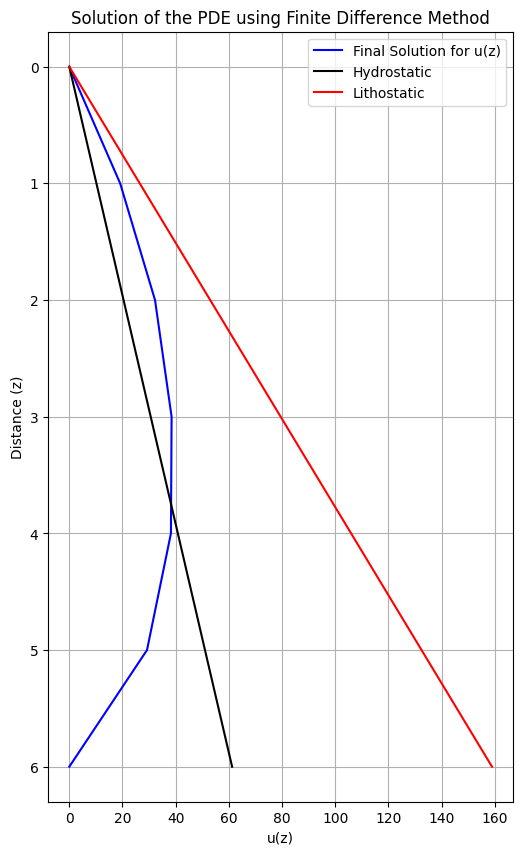

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Given pressures (example values for hydrostatic and lithostatic)
hydrostatic_pressures = [0, 10.2024, 20.4048, 30.6072, 40.8096, 51.0120, 61.2144]
lithostatic_pressures = [0, 26.4870, 52.9740, 79.4610, 105.9480, 132.4350, 158.9220]

# Calculate pressure differences
pressure_differences = [litho - hydro for litho, hydro in zip(lithostatic_pressures, hydrostatic_pressures)]

# Parameters
C = 10       # Constant C
k = 100      # Permeability k
L = 6        # Length of the domain in z (km)
T = 10       # Total time (seconds)
dz = 1       # Spatial step size (km)
dt = 0.01    # Time step size (seconds)

# Derived parameters
z_points = int(L / dz) + 1
t_points = int(T / dt) + 1

# Initialize arrays
u = np.zeros(z_points)        # Solution array for u
u_l = np.zeros(t_points)      # Assume some known function for u_l

# Example: Define u_l as a function of time (could be any function)
for t in range(t_points):
    u_l[t] = np.sin(t * dt)  # Example: sinusoidal variation

# Define porosity as a function of depth (example values)
phi = np.linspace(0.1, 0.1, z_points)  # Porosity values from 0.1 to 0.4

# Time-stepping loop
for t in range(1, t_points):
    for z in range(1, z_points - 1):
        # Calculate effective viscosity based on porosity
        nu_eff = pressure_differences[z] / (1 - phi[z]) if phi[z] < 1 else pressure_differences[z]

        du_dt = (k / nu_eff) * (u[z + 1] - 2 * u[z] + u[z - 1]) / (dz**2)  # Central difference in space
        u[z] += dt * (C / (1 - phi[z]) * du_dt + C / (1 - phi[z]) * (u_l[t] - u[z]))  # Update rule based on the equation

# Plotting the results
z_array = np.linspace(0, L, z_points)
print(z_array)
print(u)

u = -u*10**2
plt.figure(figsize=(6, 10))
plt.plot(u, z_array, label='Final Solution for u(z)', color='blue')
plt.plot(hydrostatic_pressures, z_array, label='Hydrostatic', color='black')
plt.plot(lithostatic_pressures, z_array, label='Lithostatic', color='red')
plt.title('Solution of the PDE using Finite Difference Method')
plt.ylabel('Distance (z)')
plt.xlabel('u(z)')
plt.grid(True)
plt.legend()

# Invert y-axis
plt.gca().invert_yaxis()

plt.show()

<ipython-input-67-ef373ea2941b>:45: RuntimeWarning: overflow encountered in scalar multiply
  P[z] += dt * (C / (1 - phi[z]) * dP_dt + C / (1 - phi[z]) * (P_l[t] - P[z]))
<ipython-input-67-ef373ea2941b>:42: RuntimeWarning: invalid value encountered in scalar add
  dP_dt = (k / nu_eff) * (P[z + 1] - 2 * P[z] + P[z - 1]) / (dz**2)
<ipython-input-67-ef373ea2941b>:42: RuntimeWarning: invalid value encountered in scalar subtract
  dP_dt = (k / nu_eff) * (P[z + 1] - 2 * P[z] + P[z - 1]) / (dz**2)


[ 0. nan nan nan nan nan  0.]


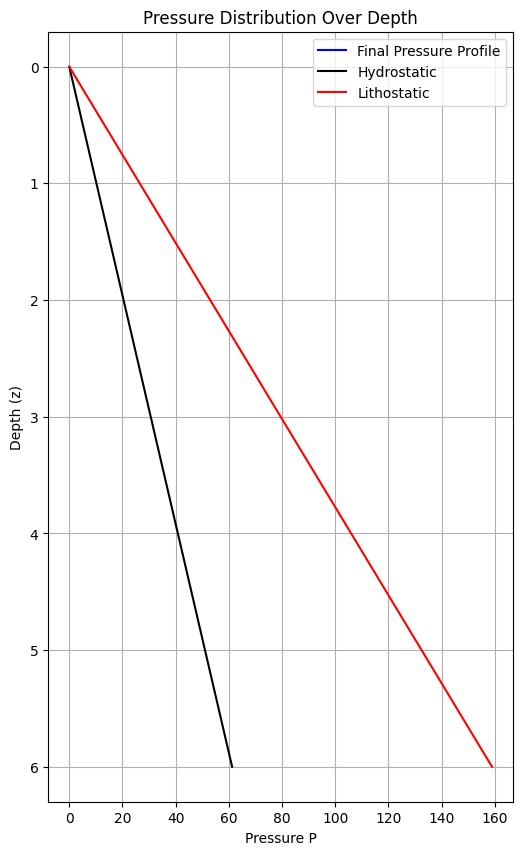

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Given pressures (example values for hydrostatic and lithostatic)
hydrostatic_pressures = [0, 10.2024, 20.4048, 30.6072, 40.8096, 51.0120, 61.2144]
lithostatic_pressures = [0, 26.4870, 52.9740, 79.4610, 105.9480, 132.4350, 158.9220]

# Calculate pressure differences
pressure_differences = [litho - hydro for litho, hydro in zip(lithostatic_pressures, hydrostatic_pressures)]

# Parameters
C = 10       # Constant C
k = 100      # Permeability k
nu = 1.0     # Viscosity nu
L = 6        # Length of the domain in z (km)
T = 10       # Total time (seconds)
dz = 1       # Spatial step size (km)
dt = 0.01    # Time step size (seconds)

# Derived parameters
z_points = int(L / dz) + 1
t_points = int(T / dt) + 1

# Initialize arrays
P = np.zeros(z_points)        # Solution array for pressure P
P_l = np.zeros(t_points)      # Assume some known function for Pl

# Set P_l equal to pressure differences over time
for t in range(t_points):
    P_l[t] = pressure_differences[min(t, len(pressure_differences)-1)]  # Use last value if t exceeds length

# Define porosity as a function of depth (example values)
phi = np.linspace(0.1, 0.1, z_points)  # Porosity values from 0.1 to 0.4

# Time-stepping loop
for t in range(1, t_points):
    for z in range(1, z_points - 1):
        # Calculate effective viscosity based on porosity
        nu_eff = nu / (1 - phi[z]) if phi[z] < 1 else nu

        # Central difference in space and time
        dP_dt = (k / nu_eff) * (P[z + 1] - 2 * P[z] + P[z - 1]) / (dz**2)

        # Update rule based on the equation
        P[z] += dt * (C / (1 - phi[z]) * dP_dt + C / (1 - phi[z]) * (P_l[t] - P[z]))

# Plotting the results
z_array = np.linspace(0, L, z_points)
print(P)
plt.figure(figsize=(6, 10))
plt.plot(P, z_array, label='Final Pressure Profile', color='blue')
plt.plot(hydrostatic_pressures, z_array[:len(hydrostatic_pressures)], label='Hydrostatic', color='black')
plt.plot(lithostatic_pressures, z_array[:len(lithostatic_pressures)], label='Lithostatic', color='red')
plt.title('Pressure Distribution Over Depth')
plt.ylabel('Depth (z)')
plt.xlabel('Pressure P')
plt.grid(True)
plt.legend()

# Invert y-axis for depth representation
plt.gca().invert_yaxis()

plt.show()